# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups            
Sample_144  P04114                       15.089
Sample_036  Q7Z7M0                       19.816
Sample_176  A0A0C4DGV8;Q13214;Q13214-2   16.099
Sample_055  Q5FWE3;Q5FWE3-3              17.234
Sample_122  P08571                       20.495
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups          
Sample_030  P10636-2;P10636-6          14.307
Sample_204  Q8N6C5;Q8N6C5-2;Q8N6C5-4   15.461
Sample_082  P08581;P08581-2            12.842
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.794
            A0A075B6Q5                 12.116
            A0A075B6R2                 12.780
            A0A075B6S5                 12.567
            A0A087WSY4                 14.278
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.247
            Q9UI40;Q9UI40-2            12.257
            Q9UIW2                     12.765
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.561
            Q9UP79                     12.373
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.233,15.050,16.842,19.863,16.057,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.628,19.067,...,15.528,15.576,14.192,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.952,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.455,17.705,17.039,16.029,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.374,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.641,15.345,17.084,18.708,14.249,19.433,11.141,11.135
Sample_207,15.739,16.877,15.469,16.898,14.702,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.794,...,16.012,15.178,13.360,15.050,16.842,19.863,11.919,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.101,19.067,16.188,...,15.528,15.576,11.612,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.951,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.577,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.224,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.877,15.345,17.084,18.708,14.249,19.433,12.353,11.741
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 413.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.87it/s]

100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.21it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.69it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.72it/s]

100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.71it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.57it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.77it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.39it/s]

100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.53it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.41it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.10it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.02it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.03it/s]

100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.20it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.47it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.92it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.62it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.44it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.29it/s]

100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.41it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.03it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.64it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.28it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.09it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.00it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.02it/s]

100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

100%|██████████| 9/9 [00:02<00:00,  3.27it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.53it/s]

 30%|███       | 3/10 [00:00<00:02,  3.39it/s]

 40%|████      | 4/10 [00:01<00:02,  2.95it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.98it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.87it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.89it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.90it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.98it/s]

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.63it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.98it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.56it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.52it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.64it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.64it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.69it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.72it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.70it/s]

100%|██████████| 11/11 [00:04<00:00,  2.71it/s]

100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.33it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.42it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.79it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.47it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.53it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.67it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.74it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.76it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.58it/s]

100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

100%|██████████| 12/12 [00:04<00:00,  2.74it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.81it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.30it/s]

 31%|███       | 4/13 [00:00<00:02,  3.94it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.96it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.53it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.46it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.46it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.67it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.73it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.56it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.25it/s]

100%|██████████| 13/13 [00:05<00:00,  2.11it/s]

100%|██████████| 13/13 [00:05<00:00,  2.60it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.20it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.98it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.88it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.95it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.81it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.61it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.40it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.30it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.35it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.40it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.53it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.55it/s]

100%|██████████| 14/14 [00:05<00:00,  2.57it/s]

100%|██████████| 14/14 [00:05<00:00,  2.61it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.03it/s]

 20%|██        | 3/15 [00:00<00:02,  4.32it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.86it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.67it/s]

 40%|████      | 6/15 [00:01<00:02,  3.19it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.69it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.29it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.07it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.01it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.97it/s]

 80%|████████  | 12/15 [00:04<00:01,  1.87it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.94it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.16it/s]

100%|██████████| 15/15 [00:06<00:00,  2.40it/s]

100%|██████████| 15/15 [00:06<00:00,  2.46it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.057 0.018          0.849 0.244       0.147   
2             0.004 0.001      0.053 0.016          0.701 0.093       0.605   
3             0.004 0.003      0.055 0.019          0.719 0.086       0.666   
4             0.004 0.000      0.048 0.006          0.719 0.087       0.682   
5             0.005 0.004      0.062 0.024          0.720 0.094       0.696   
6             0.005 0.004      0.058 0.018          0.809 0.092       0.835   
7             0.004 0.000      0.045 0.003          0.810 0.087       0.840   
8             0.004 0.002      0.046 0.005          0.801 0.084       0.816   
9             0.004 0.001      0.043 0.010          0.809 0.078       0.831   
10            0.004 0.002      0.049 0.009          0.812 0.083       0.834   
11            0.004 0.001      0.050 0.016          0.838 0.077       0.830   
12            0.007 0.005      0.075 0.029          0.838 0.083       0.828   
13            0.006 0.007      0.059 0.021          0.835 0.081       0.823   
14            0.006 0.004      0.072 0.030          0.833 0.082       0.830   
15            0.005 0.004      0.058 0.025          0.831 0.082       0.828   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.243 0.120                  0.565 0.042        0.857   
2          0.106   0.644 0.081                  0.706 0.061        0.786   
3          0.107   0.685 0.075                  0.735 0.057        0.808   
4          0.114   0.692 0.076                  0.741 0.058        0.806   
5          0.108   0.702 0.079                  0.747 0.063        0.819   
6          0.106   0.816 0.071                  0.843 0.061        0.895   
7          0.104   0.819 0.066                  0.845 0.057        0.895   
8          0.103   0.803 0.065                  0.832 0.055        0.899   
9          0.100   0.816 0.069                  0.843 0.059        0.915   
10         0.100   0.819 0.069                  0.845 0.060        0.916   
11         0.100   0.830 0.069                  0.855 0.058        0.919   
12         0.103   0.828 0.070                  0.854 0.059        0.918   
13         0.099   0.825 0.069                  0.851 0.058        0.917   
14         0.102   0.827 0.071                  0.853 0.060        0.916   
15         0.102   0.825 0.070                  0.851 0.059        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.826 0.087        210.000 0.000  
2          0.066                  0.761 0.085        210.000 0.000  
3          0.064                  0.771 0.087        210.000 0.000  
4          0.063                  0.766 0.087        210.000 0.000  
5          0.062                  0.784 0.086        210.000 0.000  
6          0.054                  0.869 0.062        210.000 0.000  
7          0.053                  0.869 0.061        210.000 0.000  
8          0.052                  0.877 0.058        210.000 0.000  
9          0.048                  0.906 0.047        210.000 0.000  
10         0.049                  0.910 0.047        210.000 0.000  
11         0.049                  0.909 0.049        210.000 0.000  
12         0.050                  0.907 0.050        210.000 0.000  
13         0.050                  0.906 0.050        210.000 0.000  
14         0.049                  0.905 0.049        210.000 0.000  
15         0.049                  0.904 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 83.70it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.15it/s]

100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.75it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.37it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.35it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.35it/s]

100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.01it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.21it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.02it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.10it/s]

100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.55it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.34it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  1.96it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.85it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.78it/s]

100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.10it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.17it/s]

 50%|█████     | 4/8 [00:01<00:02,  1.84it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.69it/s]

 75%|███████▌  | 6/8 [00:03<00:01,  1.68it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.81it/s]

100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.03it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.66it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.08it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.79it/s]

 67%|██████▋   | 6/9 [00:03<00:01,  1.76it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.75it/s]

 89%|████████▉ | 8/9 [00:04<00:00,  1.87it/s]

100%|██████████| 9/9 [00:04<00:00,  1.96it/s]

100%|██████████| 9/9 [00:04<00:00,  2.01it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.76it/s]

 30%|███       | 3/10 [00:00<00:01,  3.68it/s]

 40%|████      | 4/10 [00:01<00:02,  2.97it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.25it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.84it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.66it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.61it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.81it/s]

100%|██████████| 10/10 [00:04<00:00,  1.92it/s]

100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.82it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.07it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.59it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.26it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.14it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.24it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.95it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.74it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.62it/s]

100%|██████████| 11/11 [00:05<00:00,  1.74it/s]

100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.14it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.91it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.35it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.25it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.12it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.01it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.54it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.03it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.70it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.52it/s]

100%|██████████| 12/12 [00:05<00:00,  1.59it/s]

100%|██████████| 12/12 [00:05<00:00,  2.16it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.44it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.05it/s]

 31%|███       | 4/13 [00:01<00:03,  2.88it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.88it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.94it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.94it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.54it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.27it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.04it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.01it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.18it/s]

100%|██████████| 13/13 [00:05<00:00,  2.08it/s]

100%|██████████| 13/13 [00:05<00:00,  2.41it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.98it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.84it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.20it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.00it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.06it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.09it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.14it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.29it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.30it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.09it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.97it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.89it/s]

100%|██████████| 14/14 [00:06<00:00,  1.98it/s]

100%|██████████| 14/14 [00:06<00:00,  2.15it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.86it/s]

 20%|██        | 3/15 [00:00<00:02,  4.25it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.51it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.27it/s]

 40%|████      | 6/15 [00:01<00:02,  3.12it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.66it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.26it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.94it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.90it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.01it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.07it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.27it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.33it/s]

100%|██████████| 15/15 [00:06<00:00,  2.37it/s]

100%|██████████| 15/15 [00:06<00:00,  2.47it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.054 0.019          0.087 0.248       0.009   
2             0.005 0.004      0.055 0.020          0.760 0.122       0.636   
3             0.005 0.003      0.063 0.021          0.774 0.097       0.702   
4             0.004 0.002      0.054 0.016          0.766 0.094       0.696   
5             0.005 0.003      0.052 0.012          0.758 0.090       0.707   
6             0.004 0.003      0.048 0.013          0.767 0.093       0.691   
7             0.005 0.004      0.058 0.020          0.765 0.087       0.691   
8             0.005 0.003      0.060 0.024          0.773 0.091       0.790   
9             0.005 0.004      0.066 0.030          0.773 0.094       0.782   
10            0.005 0.003      0.066 0.026          0.774 0.095       0.782   
11            0.005 0.003      0.069 0.028          0.802 0.098       0.778   
12            0.005 0.002      0.058 0.019          0.812 0.095       0.786   
13            0.007 0.006      0.070 0.027          0.826 0.092       0.804   
14            0.007 0.006      0.079 0.030          0.824 0.091       0.802   
15            0.004 0.002      0.048 0.008          0.821 0.095       0.790   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.863   
2          0.124   0.683 0.095                  0.739 0.074        0.794   
3          0.111   0.729 0.073                  0.773 0.057        0.855   
4          0.112   0.723 0.078                  0.768 0.060        0.855   
5          0.103   0.725 0.069                  0.768 0.053        0.856   
6          0.104   0.721 0.072                  0.766 0.056        0.857   
7          0.114   0.719 0.074                  0.766 0.056        0.857   
8          0.114   0.776 0.077                  0.808 0.065        0.893   
9          0.109   0.772 0.074                  0.805 0.063        0.891   
10         0.111   0.772 0.077                  0.805 0.065        0.893   
11         0.113   0.783 0.079                  0.816 0.065        0.907   
12         0.113   0.793 0.081                  0.824 0.067        0.916   
13         0.101   0.810 0.077                  0.838 0.064        0.918   
14         0.103   0.808 0.075                  0.836 0.063        0.918   
15         0.109   0.801 0.082                  0.831 0.068        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.087        210.000 0.000  
2          0.074                  0.737 0.094        210.000 0.000  
3          0.057                  0.822 0.076        210.000 0.000  
4          0.056                  0.821 0.078        210.000 0.000  
5          0.056                  0.814 0.077        210.000 0.000  
6          0.060                  0.813 0.081        210.000 0.000  
7          0.058                  0.818 0.075        210.000 0.000  
8          0.052                  0.871 0.059        210.000 0.000  
9          0.053                  0.868 0.061        210.000 0.000  
10         0.052                  0.872 0.060        210.000 0.000  
11         0.048                  0.887 0.057        210.000 0.000  
12         0.046                  0.898 0.055        210.000 0.000  
13         0.047                  0.900 0.054        210.000 0.000  
14         0.047                  0.899 0.054        210.000 0.000  
15         0.047                  0.900 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 935.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 16.15it/s]

100%|██████████| 2/2 [00:00<00:00, 15.79it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.27it/s]

100%|██████████| 3/3 [00:00<00:00, 16.99it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 17.84it/s]

100%|██████████| 4/4 [00:00<00:00, 13.57it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.01it/s]

100%|██████████| 5/5 [00:00<00:00, 16.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.91it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.10it/s]

100%|██████████| 6/6 [00:00<00:00, 13.76it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.28it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.39it/s]

100%|██████████| 7/7 [00:00<00:00, 13.13it/s]

100%|██████████| 7/7 [00:00<00:00, 13.80it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 19.54it/s]

 50%|█████     | 4/8 [00:00<00:00, 15.78it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 12.91it/s]

100%|██████████| 8/8 [00:00<00:00, 12.17it/s]

100%|██████████| 8/8 [00:00<00:00, 12.98it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 16.45it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.61it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.29it/s]

100%|██████████| 9/9 [00:00<00:00, 10.80it/s]

100%|██████████| 9/9 [00:00<00:00, 11.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.81it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.03it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.05it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.04it/s]

100%|██████████| 10/10 [00:00<00:00, 12.63it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.58it/s]

 45%|████▌     | 5/11 [00:00<00:00, 16.42it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 15.62it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.08it/s]

100%|██████████| 11/11 [00:00<00:00, 11.60it/s]

100%|██████████| 11/11 [00:00<00:00, 13.10it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.12it/s]

 42%|████▏     | 5/12 [00:00<00:00, 11.54it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 11.37it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.10it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 10.72it/s]

100%|██████████| 12/12 [00:01<00:00, 11.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.78it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.00it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.87it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.85it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 10.36it/s]

100%|██████████| 13/13 [00:01<00:00, 10.26it/s]

100%|██████████| 13/13 [00:01<00:00, 10.83it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 14.72it/s]

 29%|██▊       | 4/14 [00:00<00:00, 13.51it/s]

 43%|████▎     | 6/14 [00:00<00:00, 12.01it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 11.89it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.15it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 11.36it/s]

100%|██████████| 14/14 [00:01<00:00, 11.54it/s]

100%|██████████| 14/14 [00:01<00:00, 12.01it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 17.70it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.93it/s]

 40%|████      | 6/15 [00:00<00:01,  8.10it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.08it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.10it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.28it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.20it/s]

 80%|████████  | 12/15 [00:01<00:00,  9.09it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.10it/s]

100%|██████████| 15/15 [00:01<00:00,  9.75it/s]

100%|██████████| 15/15 [00:01<00:00,  9.09it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.062 0.020          0.000 0.000       0.000   
2             0.004 0.002      0.050 0.020          0.623 0.090       0.472   
3             0.004 0.003      0.059 0.024          0.693 0.113       0.532   
4             0.004 0.001      0.050 0.011          0.690 0.095       0.557   
5             0.005 0.005      0.066 0.025          0.684 0.101       0.558   
6             0.004 0.002      0.052 0.012          0.697 0.099       0.612   
7             0.005 0.004      0.070 0.025          0.725 0.104       0.605   
8             0.005 0.003      0.053 0.015          0.690 0.098       0.614   
9             0.005 0.004      0.068 0.024          0.678 0.096       0.606   
10            0.004 0.002      0.050 0.014          0.680 0.094       0.605   
11            0.005 0.003      0.068 0.024          0.702 0.086       0.632   
12            0.005 0.003      0.052 0.014          0.702 0.087       0.632   
13            0.006 0.005      0.064 0.022          0.695 0.093       0.619   
14            0.005 0.003      0.053 0.018          0.697 0.096       0.620   
15            0.007 0.007      0.075 0.033          0.697 0.095       0.629   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.744   
2          0.094   0.531 0.083                  0.630 0.055        0.714   
3          0.100   0.596 0.088                  0.677 0.063        0.743   
4          0.113   0.610 0.094                  0.686 0.065        0.765   
5          0.110   0.608 0.093                  0.683 0.066        0.761   
6          0.111   0.645 0.081                  0.706 0.061        0.787   
7          0.116   0.650 0.084                  0.714 0.061        0.794   
8          0.109   0.643 0.085                  0.703 0.064        0.810   
9          0.112   0.633 0.085                  0.695 0.062        0.805   
10         0.114   0.632 0.085                  0.696 0.059        0.802   
11         0.110   0.659 0.079                  0.716 0.059        0.807   
12         0.111   0.659 0.083                  0.716 0.062        0.805   
13         0.116   0.648 0.090                  0.708 0.066        0.802   
14         0.118   0.649 0.091                  0.709 0.067        0.799   
15         0.117   0.655 0.088                  0.712 0.066        0.798   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.688 0.086        210.000 0.000  
2          0.060                  0.669 0.072        210.000 0.000  
3          0.068                  0.703 0.079        210.000 0.000  
4          0.071                  0.714 0.085        210.000 0.000  
5          0.074                  0.710 0.091        210.000 0.000  
6          0.070                  0.749 0.083        210.000 0.000  
7          0.066                  0.762 0.079        210.000 0.000  
8          0.069                  0.769 0.086        210.000 0.000  
9          0.067                  0.764 0.083        210.000 0.000  
10         0.069                  0.763 0.083        210.000 0.000  
11         0.068                  0.767 0.081        210.000 0.000  
12         0.067                  0.764 0.080        210.000 0.000  
13         0.065                  0.761 0.077        210.000 0.000  
14         0.065                  0.758 0.076        210.000 0.000  
15         0.066                  0.752 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,13,15
score_time,12,14,15
test_precision,1,13,7
test_recall,7,13,11
test_f1,11,13,12
test_balanced_accuracy,11,13,11
test_roc_auc,11,13,8
test_average_precision,10,13,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.71it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.00it/s]

 31%|███       | 4/13 [00:01<00:03,  2.84it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.65it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.66it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.61it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.78it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.82it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.17it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.02it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.00it/s]

100%|██████████| 13/13 [00:05<00:00,  2.01it/s]

100%|██████████| 13/13 [00:05<00:00,  2.37it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 19.72it/s]

 50%|█████     | 4/8 [00:00<00:00, 15.99it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.22it/s]

100%|██████████| 8/8 [00:00<00:00, 11.89it/s]

100%|██████████| 8/8 [00:00<00:00, 12.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.07it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.26it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.42it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.20it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.10it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.85it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.85it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.98it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.94it/s]

100%|██████████| 11/11 [00:03<00:00,  3.08it/s]

100%|██████████| 11/11 [00:03<00:00,  3.20it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


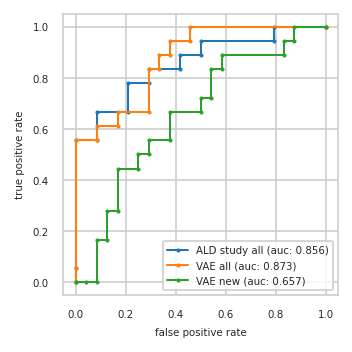

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.556   0.000 0.556   0.083 0.000
3          0.083 0.556   0.083 0.556   0.083 0.167
4          0.083 0.667   0.083 0.611   0.125 0.167
5          0.208 0.667   0.167 0.611   0.125 0.278
6          0.208 0.778   0.167 0.667   0.167 0.278
7          0.292 0.778   0.292 0.667   0.167 0.444
8          0.292 0.833   0.292 0.833   0.250 0.444
9          0.417 0.833   0.333 0.833   0.250 0.500
10         0.417 0.889   0.333 0.889   0.292 0.500
11         0.500 0.889   0.375 0.889   0.292 0.556
12         0.500 0.944   0.375 0.944   0.375 0.556
13         0.792 0.944   0.458 0.944   0.375 0.667
14         0.792 1.000   0.458 1.000   0.500 0.667
15         1.000 1.000   1.000 1.000   0.500 0.722
16           NaN   NaN     NaN   NaN   0.542 0.722
17           NaN   NaN     NaN   NaN   0.542 0.833
18           NaN   NaN     NaN   NaN   0.583 0.833
19           NaN   NaN     NaN   NaN   0.583 0.889
20           NaN   NaN     NaN   NaN   0.833 0.889
21           NaN   NaN     NaN   NaN   0.833 0.944
22           NaN   NaN     NaN   NaN   0.875 0.944
23           NaN   NaN     NaN   NaN   0.875 1.000
24           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P01597;P04432,Q93063;Q93063-3,P36269;P36269-2;P36269-3
2,P09417,A0A087WXB8;Q9Y274,P30048;P30048-2
3,P61981,P61981,P31321
4,P14174,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
5,P04075,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,P00338;P00338-3,Q14894,E9PK25;G3V1A4;P23528
7,C9JF17;P05090,P63104,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,Q6EMK4,C9JF17;P05090,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


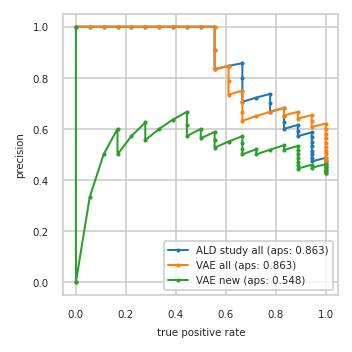

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.472 0.944     0.500 1.000     0.444 0.889
7          0.486 0.944     0.514 1.000     0.457 0.889
8          0.500 0.944     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.621 1.000     0.517 0.833
14         0.571 0.889     0.607 0.944     0.536 0.833
15         0.593 0.889     0.630 0.944     0.519 0.778
16         0.615 0.889     0.654 0.944     0.500 0.722
17         0.600 0.833     0.640 0.889     0.520 0.722
18         0.625 0.833     0.667 0.889     0.500 0.667
19         0.652 0.833     0.652 0.833     0.522 0.667
20         0.682 0.833     0.682 0.833     0.545 0.667
21         0.667 0.778     0.667 0.778     0.571 0.667
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.737 0.778     0.632 0.667     0.526 0.556
24         0.722 0.722     0.667 0.667     0.556 0.556
25         0.706 0.667     0.706 0.667     0.588 0.556
26         0.750 0.667     0.750 0.667     0.562 0.500
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.857 0.667     0.786 0.611     0.571 0.444
29         0.846 0.611     0.846 0.611     0.615 0.444
30         0.833 0.556     0.833 0.556     0.667 0.444
31         0.909 0.556     0.909 0.556     0.636 0.389
32         1.000 0.556     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


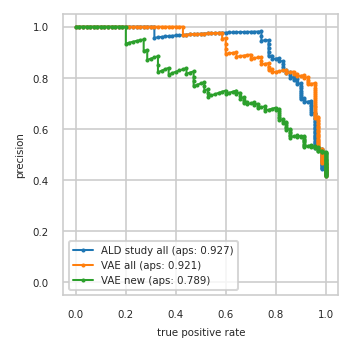

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


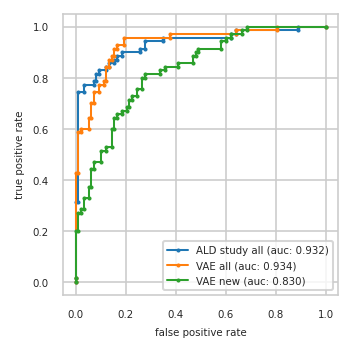

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}